## MODOS Evaluation Model Analysis

This script compares the configuration of flood mitigation options in a flood-prone region. It works in cooperation with the MODOS Evaluation Model Runner, which creates the data the we will compare here. This MODOS Evaluation Model is able to  compare a large number of flood risk reduction strategies and scenarios.

The MODOS Evaluation Model largely depends on the 'Exploratory Modelling and Analysis (EMA) Workbench', built and maintained by J.H. Kwakkel.

Other used python-packages are:
- mpld3
- ipyparallel
- pydotplus
- seaborn
- Graphviz
- SALib
- Platypus
- Borg MOEA

Version MODOS flood simulation: V1.1

Version EMA-Workbench: V1.2.1 (26-08-2018)

Last Updated: 19-09-2018

In [1]:
import sys
sys.path.append('./Packages')
%pwd

'D:\\ecvanberchum\\Surfdrive\\MODOS\\MODOS_model\\Beira'

In [2]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)

from ema_workbench.em_framework import (RealParameter, ScalarOutcome, 
                           perform_experiments, CategoricalParameter, samplers, Scenario)
from ema_workbench.util import (ema_logging)
from ema_workbench import (Model, RealParameter, ScalarOutcome, Constant,
                           ema_logging, MultiprocessingEvaluator)
from ema_workbench.em_framework.model import (Replicator,BaseModel)
from Library.MODOS_config import (save_fig,change_fontsize)

%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy as np
import seaborn as sns
import pandas as pd
import mpld3

from timeit import default_timer as timer
ema_logging.log_to_stderr(level=ema_logging.INFO)

<Logger EMA (DEBUG)>

In [3]:
from ema_workbench import load_results
results = load_results('./data/500 experiments_MODOS_Beira_30_11-2_scenarios.tar.gz')

[MainProcess/INFO] results loaded succesfully from D:\ecvanberchum\Surfdrive\MODOS\MODOS_model\Beira\data\500 experiments_MODOS_Beira_30_11-2_scenarios.tar.gz


[MainProcess/INFO] no time dimension found in results


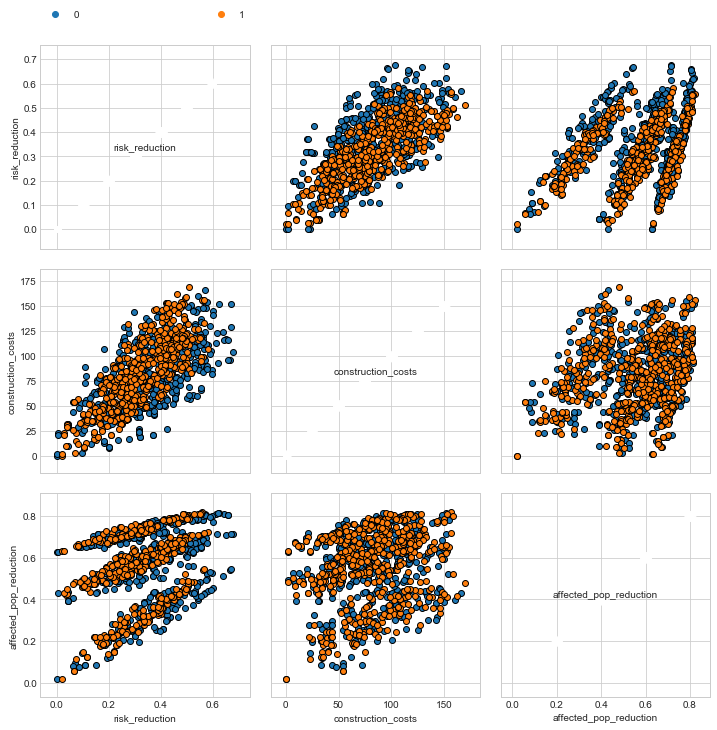

In [4]:
import ema_workbench.analysis.pairs_plotting as pairs
import itertools
#pairs.plotting_util.COLOR_LIST = sns.color_palette("PuBuGn_d",800)
#sns.set_palette(pairs.plotting_util.COLOR_LIST)

fig, axes = pairs.pairs_scatter(results, group_by='scenario_id', legend=True)
fig.set_size_inches(12,12)


save_fig(fig, './figs/', 'pair_plot')

plt.show()

# Comparing the results: Feature scoring

In the following parts of the model, the simulations can be compared with each other.
the first technique to do so is the feature scoring. This shows how much a particular outcome depends on the levers (choices of flood risk reduction measures).

This analysis tool can show a couple of things. You can change it, depending on what you seek by altering the following variables:

y = outcome['OUTCOME']       .. by changing the 'OUTCOME' value, the feature scoring runs for a different outcome variables.
 >Examples: C_con,C_repair,EnvironScore...
                                
mode=feature_scoring.'MODE'  .. by changing the 'MODE' value, the feature score runs a different kind of analysis.


C:\Program Files\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Program Files\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


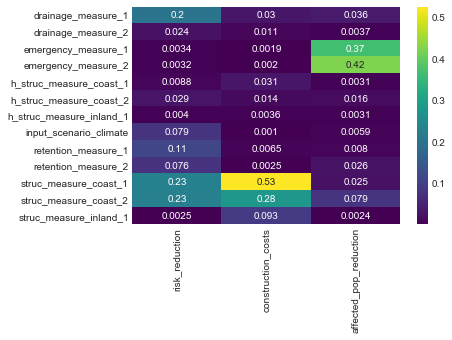

In [5]:
import numpy.lib.recfunctions as rf
from ema_workbench.analysis import feature_scoring
#results_update = results.where((pd.notnull(results)),'none')
experiments, outcomes = results

experiments = rf.drop_fields(experiments, ['model','policy'], asrecarray=True)

x = experiments
y = outcomes

# focus dataset on 1 climate scenario
#x_bool = x[x_bool==1]
#y_new = y[x_bool==1]

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

In [6]:
from ema_workbench.analysis.feature_scoring import get_feature_scores_all

y = outcomes
print(outcomes.keys())

fs_all = get_feature_scores_all(x, y)
fs_all

dict_keys(['risk_reduction', 'construction_costs', 'affected_pop_reduction'])


,risk_reduction,construction_costs,affected_pop_reduction
drainage_measure_1,0.203436,0.030609,0.036734
drainage_measure_2,0.024209,0.010958,0.003607
emergency_measure_1,0.003308,0.001944,0.367138
emergency_measure_2,0.003089,0.001903,0.424145
h_struc_measure_coast_1,0.008751,0.031527,0.002929
h_struc_measure_coast_2,0.028777,0.013916,0.015928
h_struc_measure_inland_1,0.003949,0.003585,0.003232
input_scenario_climate,0.078878,0.000977,0.005886
retention_measure_1,0.108839,0.006341,0.008077
retention_measure_2,0.075015,0.002444,0.026464


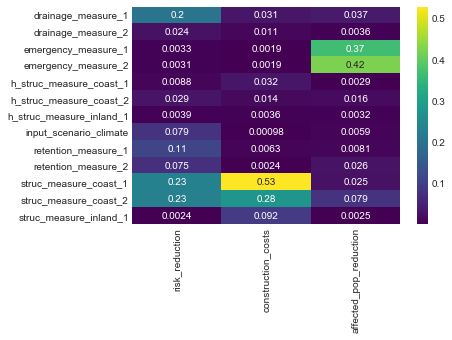

In [7]:
sns.heatmap(fs_all, annot=True, cmap='viridis')
save_fig(plt.gcf(), './figs', 'all_feature_scores')
plt.show()

## Scenario discovery using PRIM

A second analysis technique is to perform scenario discovery using either the Patient Rule Induction Method (PRIM) or Classification and Regression Trees (CART). Here we show the application of PRIM. The implementation of PRIM which comes with the workbench is designed for interactive use through jupyter notebook. In practice, the code would thus be executed in several steps and the user would make choices based on the results shown. The first step in applying scenario discovery is to specify which scenarios are of interest. Here, we use a simple classification. Any experiment where the concentration in the lake at the end of the runtime is below 1, is of interest. 

In [163]:
import mpld3 # enables interaction with trade off curve
from ema_workbench.analysis import prim
b1= outcomes['risk_reduction'] > 0.40
b2= outcomes['construction_costs'] < 125
b3= outcomes['affected_pop_reduction'] > 0.65
b4= x['input_scenario_climate'] == 'low'

y = b1*b2*b3*b4

prim_alg = prim.Prim(x,y, threshold=0.7)
box1 = prim_alg.find_box()

[MainProcess/INFO] 1000 points remaining, containing 89 cases of interest
[MainProcess/INFO] mean: 0.8076923076923077, mass: 0.052, coverage: 0.47191011235955055, density: 0.8076923076923077 restricted_dimensions: 7


The figure below shows the results for PRIM. First, we see the trade off between coverage and density. After that, we see the identified box, including information on the significance of each of the limits, and the coverage and density of the box. This particular box is the final one on the peeling trajectory shown on the left. 

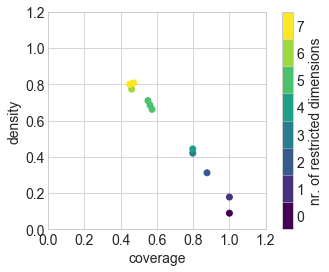

In [164]:

fig = box1.show_tradeoff()
change_fontsize(fig)
save_fig(fig, './figs/', 'prim_tradeoff')
plt.show()
#mpld3.display()

In [185]:
box1.inspect(11)

coverage     0.47191
density     0.807692
mass           0.052
mean        0.807692
res dim            7
Name: 11, dtype: object

                                                         box 11  \
                                                            min   
input_scenario_climate                                    {low}   
drainage_measure_1                      {Second_phase_drainage}   
emergency_measure_1                        {Improve_evacuation}   
struc_measure_coast_2     {Heighten_dunes_west, Floodwall_west}   
h_struc_measure_coast_2                                 8.53364   
struc_measure_coast_1             {Sand_supplements_east, none}   
h_struc_measure_inland_1                                7.50156   

                                                                 \
                                                            max   
input_scenario_climate                                    {low}   
drainage_measure_1                      {Second_phase_drainage}  

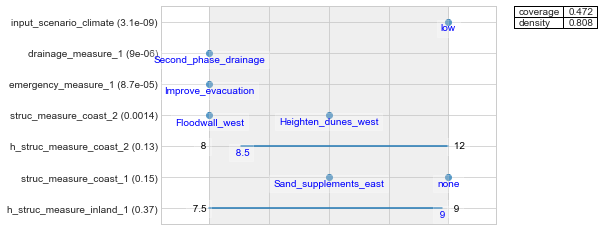

In [181]:
fig = box1.inspect(style='graph')
save_fig(fig, './figs', 'prim_boxlims')
plt.show()

In [21]:
box2 = prim_alg.find_box()

[MainProcess/INFO] 948 points remaining, containing 10 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.1111111111111111, returning dump box


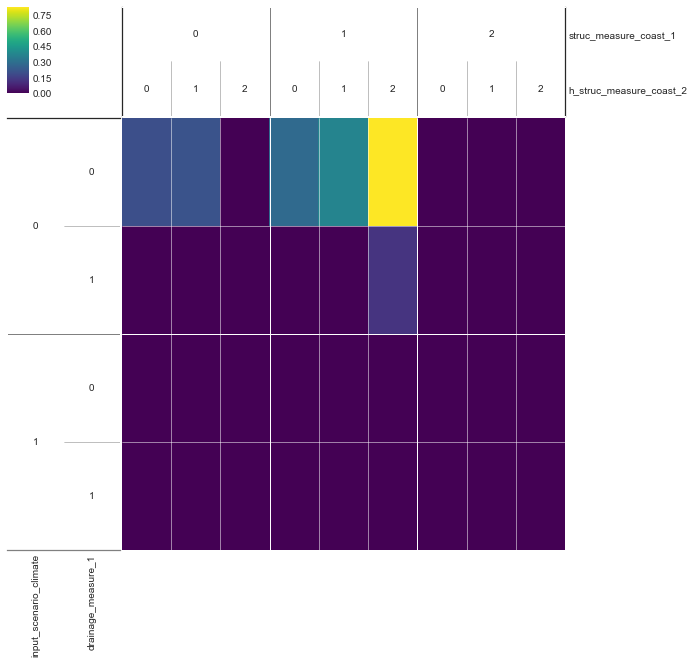

In [14]:
from ema_workbench.analysis.dimensional_stacking import create_pivot_plot

scores = create_pivot_plot(x,y, nr_levels=2)
plt.show()

In [15]:
g = sns.jointplot(xjoint, yjoint, kind="kde", size=5)

NameError: name 'xjoint' is not defined